In [2]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
source('main.R')

house_prices$helpers$import_libs()

combined_dataset <- house_prices$helpers$load_data()

combined_dataset %>% dim
combined_dataset %>% filter(dataSource == "train") %>% dim
combined_dataset %>% filter(dataSource == "test") %>% dim

[1] 2919   82

[1] 1460   82

[1] 1459   82

In [3]:
character_colnames <- house_prices$helpers$get_character_colnames(combined_dataset)
numeric_colnames <- house_prices$helpers$get_numeric_colnames(combined_dataset)

character_colnames %>% length
numeric_colnames %>% length

character_colnames
numeric_colnames

[1] 45

[1] 35

[1] "Alley"         "BldgType"      "BsmtCond"      "BsmtExposure" 
 [5] "BsmtFinType1"  "BsmtFinType2"  "BsmtQual"      "CentralAir"   
 [9] "Condition1"    "Condition2"    "Electrical"    "ExterCond"    
[13] "Exterior1st"   "Exterior2nd"   "ExterQual"     "Fence"        
[17] "FireplaceQu"   "Foundation"    "Functional"    "GarageCond"   
[21] "GarageFinish"  "GarageQual"    "GarageType"    "Heating"      
[25] "HeatingQC"     "HouseStyle"    "KitchenQual"   "LandContour"  
[29] "LandSlope"     "LotConfig"     "LotShape"      "MasVnrType"   
[33] "MiscFeature"   "MoSold"        "MSSubClass"    "MSZoning"     
[37] "Neighborhood"  "PavedDrive"    "PoolQC"        "RoofMatl"     
[41] "RoofStyle"     "SaleCondition" "SaleType"      "Street"       
[45] "Utilities"

[1] "BedroomAbvGr"  "BsmtFinSF1"    "BsmtFinSF2"    "BsmtFullBath" 
 [5] "BsmtHalfBath"  "BsmtUnfSF"     "EnclosedPorch" "Fireplaces"   
 [9] "FullBath"      "GarageArea"    "GarageCars"    "GarageYrBlt"  
[13] "GrLivArea"     "HalfBath"      "KitchenAbvGr"  "LotArea"      
[17] "LotFrontage"   "LowQualFinSF"  "MasVnrArea"    "MiscVal"      
[21] "OpenPorchSF"   "OverallCond"   "OverallQual"   "PoolArea"     
[25] "SalePrice"     "ScreenPorch"   "TotalBsmtSF"   "TotRmsAbvGrd" 
[29] "WoodDeckSF"    "X1stFlrSF"     "X2ndFlrSF"     "X3SsnPorch"   
[33] "YearBuilt"     "YearRemodAdd"  "YrSold"

In [4]:
categ_data <- 
    combined_dataset %>% 
    select(house_prices$helpers$get_character_colnames(combined_dataset), SalePrice)

numeric_data <- 
    combined_dataset %>% 
    select(house_prices$helpers$get_numeric_colnames(combined_dataset))

In [5]:
categ_data %>% glimpse(50)

Observations: 2,919
Variables: 46
$ Alley         <chr> NA, NA, NA, NA, NA, NA,...
$ BldgType      <chr> "1Fam", "1Fam", "1Fam",...
$ BsmtCond      <chr> "TA", "TA", "TA", "Gd",...
$ BsmtExposure  <chr> "No", "Gd", "Mn", "No",...
$ BsmtFinType1  <chr> "GLQ", "ALQ", "GLQ", "A...
$ BsmtFinType2  <chr> "Unf", "Unf", "Unf", "U...
$ BsmtQual      <chr> "Gd", "Gd", "Gd", "TA",...
$ CentralAir    <chr> "Y", "Y", "Y", "Y", "Y"...
$ Condition1    <chr> "Norm", "Feedr", "Norm"...
$ Condition2    <chr> "Norm", "Norm", "Norm",...
$ Electrical    <chr> "SBrkr", "SBrkr", "SBrk...
$ ExterCond     <chr> "TA", "TA", "TA", "TA",...
$ Exterior1st   <chr> "VinylSd", "MetalSd", "...
$ Exterior2nd   <chr> "VinylSd", "MetalSd", "...
$ ExterQual     <chr> "Gd", "TA", "Gd", "TA",...
$ Fence         <chr> NA, NA, NA, NA, NA, "Mn...
$ FireplaceQu   <chr> NA, "TA", "TA", "Gd", "...
$ Foundation    <chr> "PConc", "CBlock", "PCo...
$ Functional    <chr> "Typ", "Typ", "Typ", "T...
$ GarageCond    <chr> "TA", "TA", "

In [6]:
numeric_data %>% glimpse(50)

Observations: 2,919
Variables: 35
$ BedroomAbvGr  <int> 3, 3, 3, 3, 4, 1, 3, 3,...
$ BsmtFinSF1    <int> 706, 978, 486, 216, 655...
$ BsmtFinSF2    <int> 0, 0, 0, 0, 0, 0, 0, 32...
$ BsmtFullBath  <int> 1, 0, 1, 1, 1, 1, 1, 1,...
$ BsmtHalfBath  <int> 0, 1, 0, 0, 0, 0, 0, 0,...
$ BsmtUnfSF     <int> 150, 284, 434, 540, 490...
$ EnclosedPorch <int> 0, 0, 0, 272, 0, 0, 0, ...
$ Fireplaces    <int> 0, 1, 1, 1, 1, 0, 1, 2,...
$ FullBath      <int> 2, 2, 2, 1, 2, 1, 2, 2,...
$ GarageArea    <int> 548, 460, 608, 642, 836...
$ GarageCars    <int> 2, 2, 2, 3, 3, 2, 2, 2,...
$ GarageYrBlt   <int> 2003, 1976, 2001, 1998,...
$ GrLivArea     <int> 1710, 1262, 1786, 1717,...
$ HalfBath      <int> 1, 0, 1, 0, 1, 1, 0, 1,...
$ KitchenAbvGr  <int> 1, 1, 1, 1, 1, 1, 1, 1,...
$ LotArea       <int> 8450, 9600, 11250, 9550...
$ LotFrontage   <int> 65, 80, 68, 60, 84, 85,...
$ LowQualFinSF  <int> 0, 0, 0, 0, 0, 0, 0, 0,...
$ MasVnrArea    <int> 196, 0, 162, 0, 350, 0,...
$ MiscVal       <int> 0, 0, 0, 0, 0

# Entropy

In [7]:
entropy <- house_prices$attributes_selection$entropy

In [8]:
categ_vars_by_entropy <- 
    entropy$arrange_vars(
        categ_data %>% select(-SalePrice)
    )

categ_vars_by_entropy %>% head
categ_vars_by_entropy %>% tail

var,entropy
Utilities,0.01262749
PoolQC,0.03820308
Street,0.03850369
Condition2,0.10643374
RoofMatl,0.13851938
Heating,0.13977521


var,entropy
BsmtFinType1,2.454724
Exterior1st,2.723429
Exterior2nd,2.800720
MSSubClass,2.920021
MoSold,3.393870
Neighborhood,4.212100


In [9]:
numeric_vars_by_entropy <- 
    entropy$arrange_vars(
        numeric_data %>% select(-SalePrice)
    )

numeric_vars_by_entropy %>% head
numeric_vars_by_entropy %>% tail

var,entropy
PoolArea,0.05767714
X3SsnPorch,0.15876902
LowQualFinSF,0.17326513
KitchenAbvGr,0.28095915
BsmtHalfBath,0.34480765
MiscVal,0.37490332


var,entropy
GarageArea,7.968793
TotalBsmtSF,9.348757
BsmtUnfSF,9.390885
X1stFlrSF,9.601608
GrLivArea,9.882939
LotArea,10.400602


# Normal Paper

In [10]:
combined_dataset %>% 
select(price=SalePrice) %>% 
na.omit %>%
mutate(
    price_log = log(price + 1)
) %>%
gather(var, value) %>%
group_by(var) %>%
mutate(
    normed_value = (value - mean(value)) / sd(value)
) -> target_normal_paper

target_normal_paper %>% arrange(var, value) %>% top_n(3, value)

var,value,normed_value
price,625000.00000,5.589940
price,745000.00000,7.100466
price,755000.00000,7.226343
price_log,13.34551,3.308183
price_log,13.52114,3.747869
price_log,13.53447,3.781248


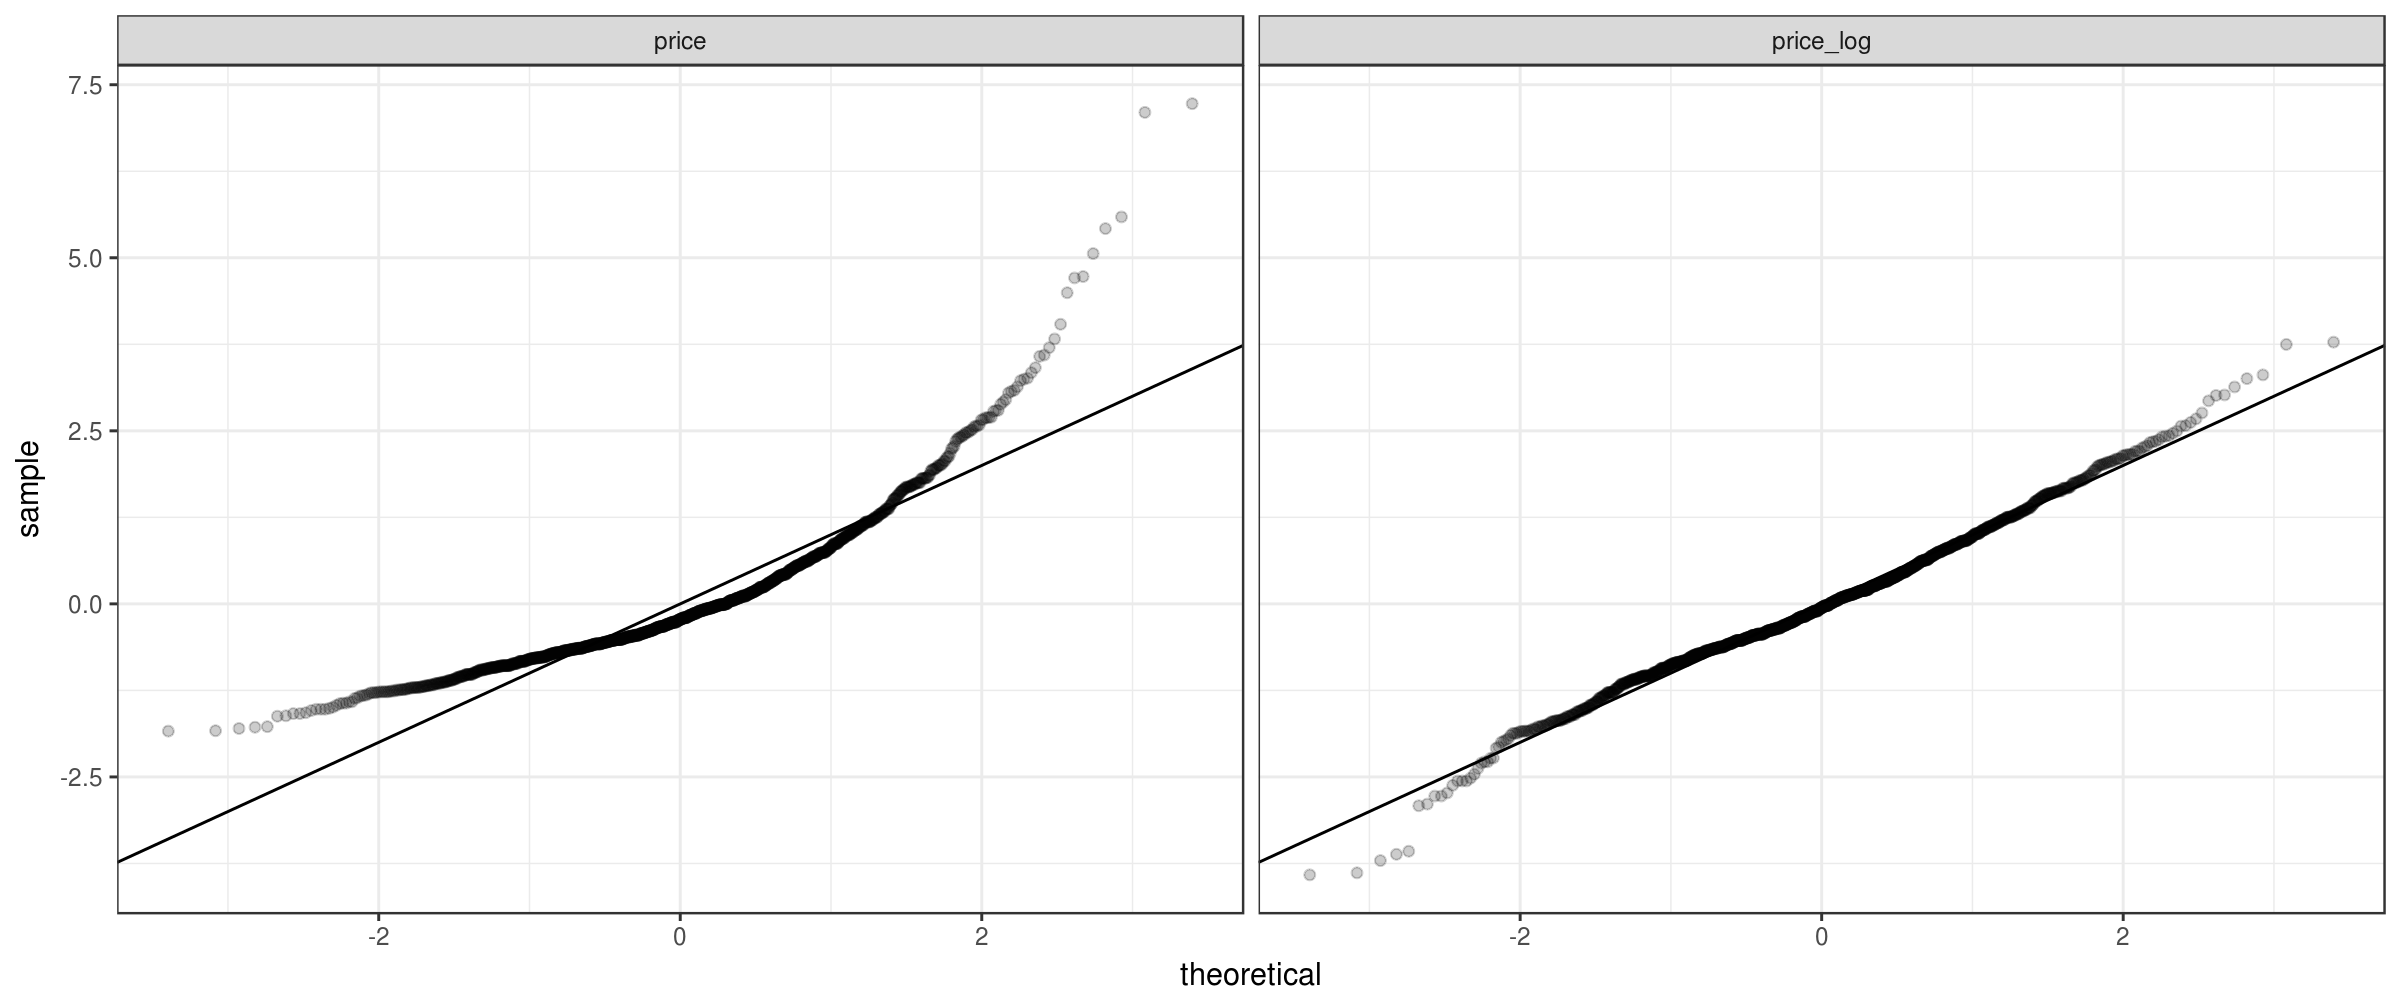

In [13]:
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res=200)

target_normal_paper %>%
ggplot() +
geom_qq(aes(sample=normed_value), alpha=0.2) +
facet_wrap(~var, ncol=2) +
geom_abline(slope=1) +
theme_bw()

In [14]:
target_normal_paper %>%
group_by(var, normed_value) %>%
arrange(var, normed_value) %>%
summarise(
    k = n()
) %>%
mutate(
    empirical = cumsum(k) / sum(k),
    theoretical = pnorm(normed_value),
    L2_delta = k*(empirical - theoretical)**2
) %>% 
group_by(var) %>%
summarise(
    L2 = sum(L2_delta)
)

var,L2
price,7.4623329
price_log,0.6496542


# Separation between groups

In [15]:
groups_separation <- house_prices$attributes_selection$groups_separation

precalculated <- 
    groups_separation$precalculated(
        df = categ_data,
        target_var = SalePrice
    )

precalculated %>% head(5)

var,value,n,mean,std,freq,lead_mean,lead_freq,lead_std
Alley,Grvl,50,122219.1,34780.78,0.03424658,168000.6,0.02808219,38370.38
Alley,Pave,41,168000.6,38370.38,0.02808219,183452.1,0.93767123,80667.15
Alley,NA,1369,183452.1,80667.15,0.93767123,NA,NA,NA
BldgType,2fmCon,31,128432.3,35458.55,0.02123288,133541.1,0.03561644,27833.25
BldgType,Duplex,52,133541.1,27833.25,0.03561644,135911.6,0.02945205,41013.22


In [16]:
categ_vars_by_groups_separation <- groups_separation$arrange_vars(categ_data, SalePrice)

In [17]:
categ_vars_by_groups_separation %>% head

var,score
Utilities,0.0002047587
LotConfig,0.0005070409
Functional,0.0006479951
MoSold,0.0007162101
PoolQC,0.0010659277
Condition2,0.0012226735


In [18]:
categ_vars_by_groups_separation %>% tail

var,score
BsmtFinType1,0.1211155
CentralAir,0.2042301
GarageFinish,0.2756040
BsmtQual,0.4210981
KitchenQual,0.4775291
ExterQual,0.4871526


In [19]:
source('main.R')

order_factor_by_target <- house_prices$attributes_selection$order_factor_by_target

order_factor_by_target(
    df = categ_data %>% filter(!is.na(SalePrice)) %>% select(ExterQual, SalePrice), 
    factor_var = ExterQual, 
    target_var = SalePrice
)$ExterQual %>% levels

[1] "Fa" "TA" "Gd" "Ex"

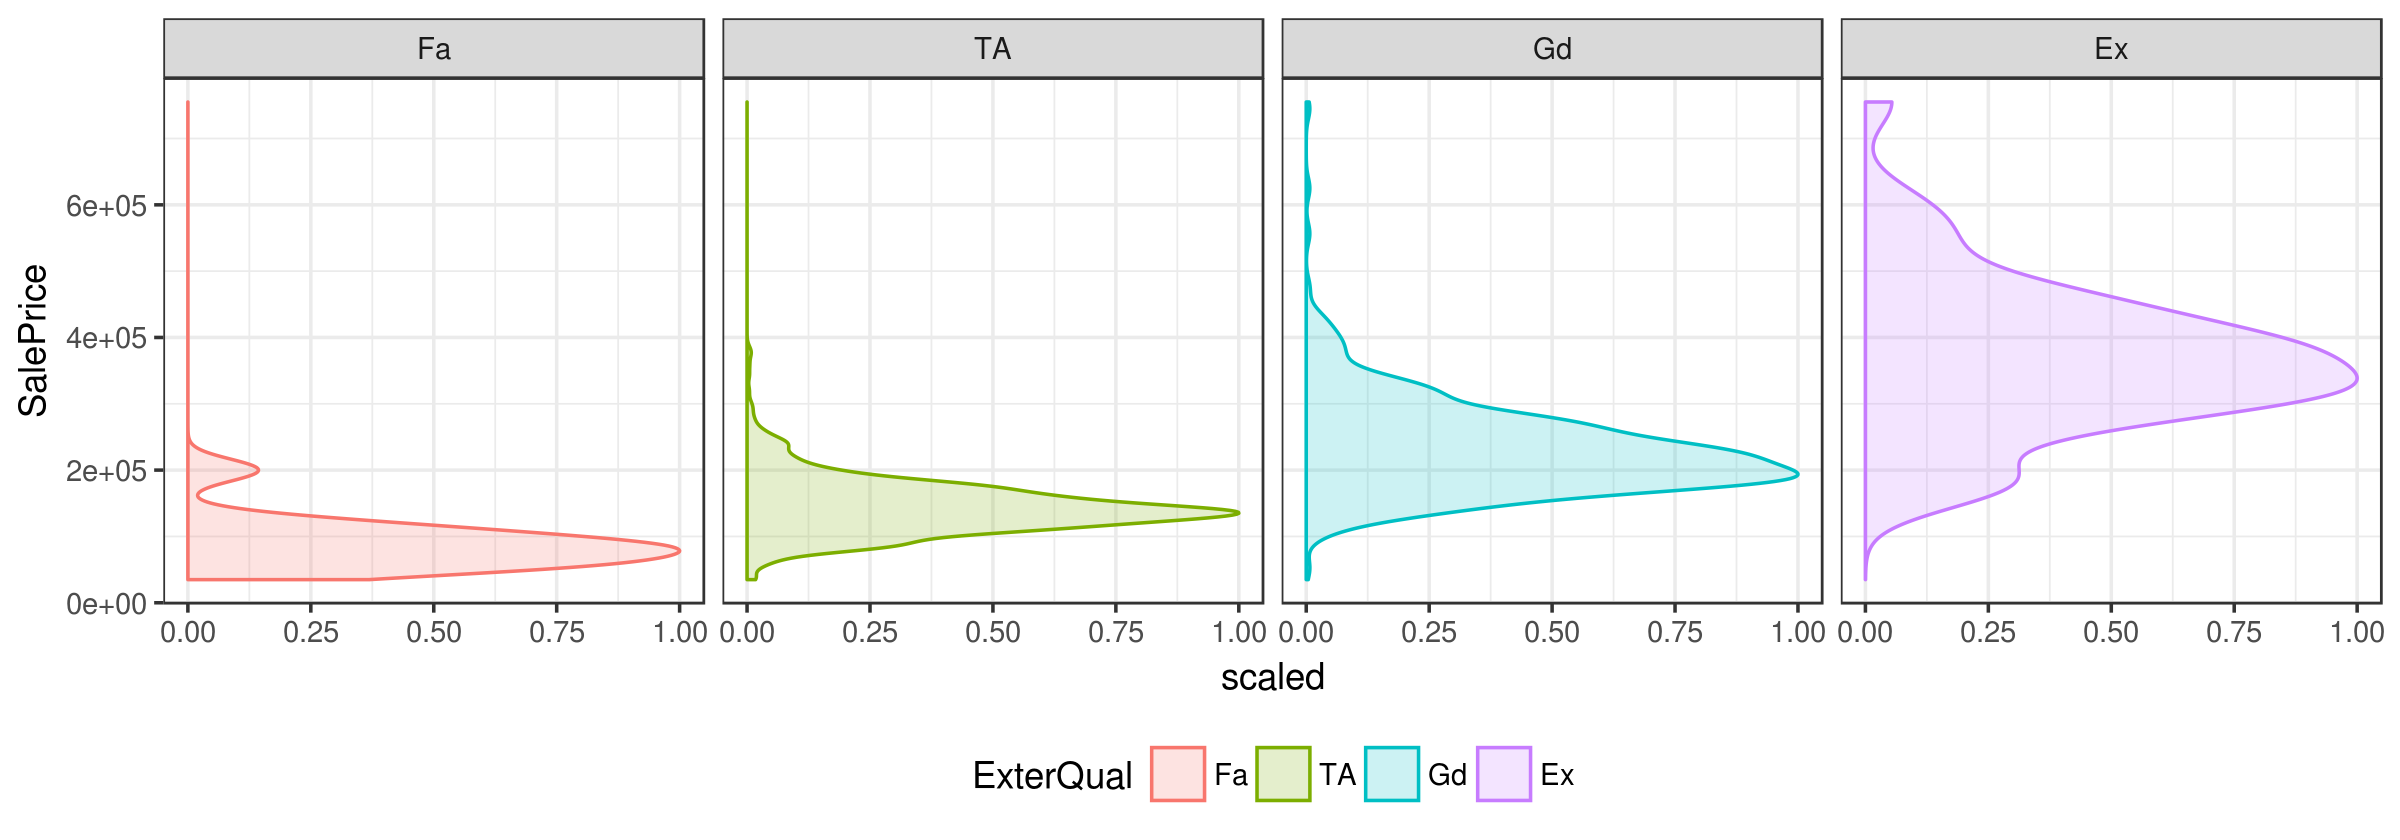

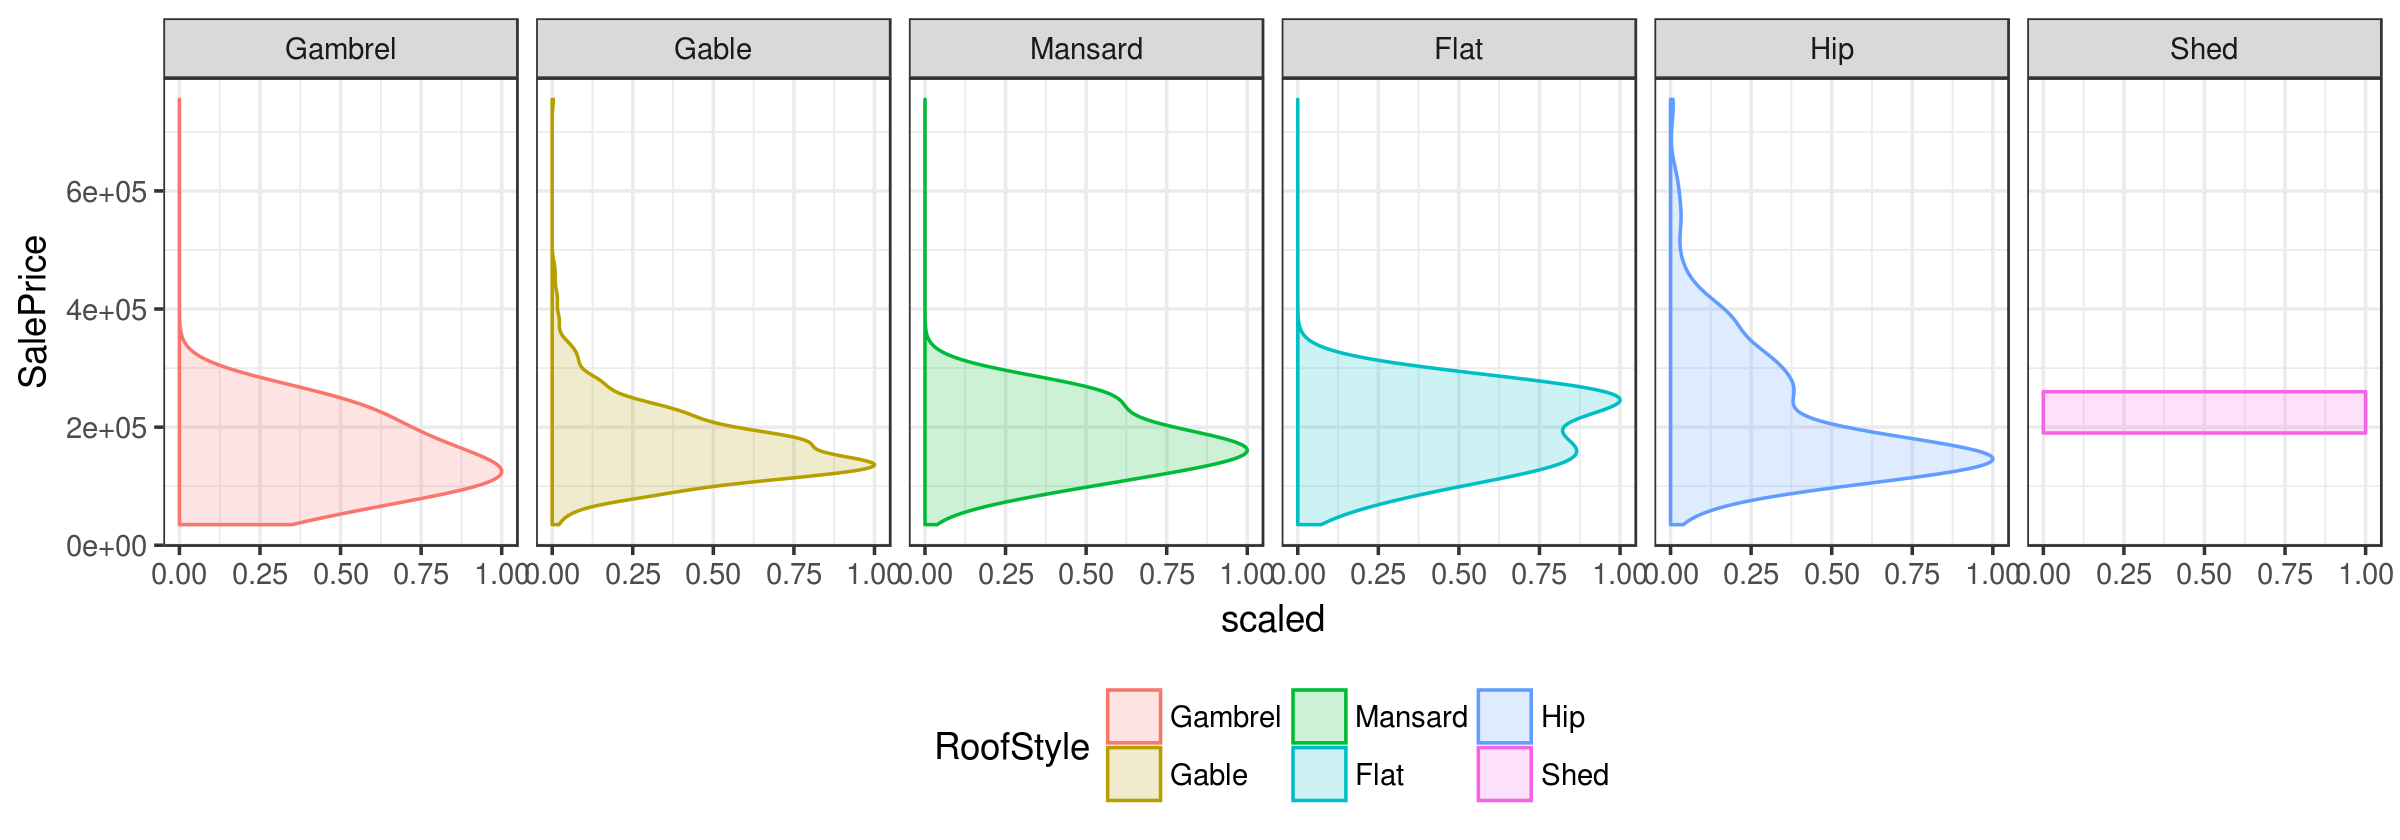

In [36]:
options(repr.plot.width = 10, repr.plot.height = 3.5, repr.plot.res=240)

order_factor_by_target(
    df = categ_data %>% filter(!is.na(SalePrice)) %>% select(ExterQual, SalePrice), 
    factor_var = ExterQual, 
    target_var = SalePrice
) %>%
ggplot(aes(SalePrice, color=ExterQual)) +
geom_density(aes(y=..scaled.., fill=ExterQual), alpha=.2) +
facet_wrap(~ExterQual, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom")


order_factor_by_target(
    df = categ_data %>% filter(!is.na(SalePrice)) %>% select(RoofStyle, SalePrice), 
    factor_var = RoofStyle, 
    target_var = SalePrice
) %>%
ggplot(aes(SalePrice, color=RoofStyle)) +
geom_density(aes(y=..scaled.., fill=RoofStyle), alpha=.2) +
facet_wrap(~RoofStyle, nrow=1) +
coord_flip() +
theme_bw() +
theme(legend.position="bottom")

# By $R^2$

In [21]:
Rsquared <- house_prices$attributes_selection$Rsquared
categ_vars_by_r2 <- Rsquared$arrange_vars(categ_data, SalePrice)
numeric_vars_by_r2 <- Rsquared$arrange_vars(numeric_data, SalePrice)

In [22]:
categ_vars_by_r2 %>% head(8)

var,r2
Utilities,0.0002048991
Street,0.0016839152
LandSlope,0.0026816256
MoSold,0.0072240344
BsmtFinType2,0.0094523506
Condition2,0.0098991607
Heating,0.0144371354
Functional,0.0164803857


In [23]:
categ_vars_by_r2 %>% tail(8)

var,r2
Foundation,0.2563684
GarageFinish,0.2672764
Alley,0.2854967
PoolQC,0.4486514
BsmtQual,0.4537561
KitchenQual,0.4565986
ExterQual,0.4773878
Neighborhood,0.5455750


In [24]:
numeric_vars_by_r2 %>% head(8)

var,r2
BsmtFinSF2,0.0001294616
BsmtHalfBath,0.0002837255
MiscVal,0.0004489983
LowQualFinSF,0.0006556739
YrSold,0.0008365159
X3SsnPorch,0.0019877032
OverallCond,0.0060615402
PoolArea,0.0085384160


In [25]:
numeric_vars_by_r2 %>% tail(8)

var,r2
TotRmsAbvGrd,0.2848604
FullBath,0.3143439
X1stFlrSF,0.3670569
TotalBsmtSF,0.3764811
GarageArea,0.3886668
GarageCars,0.4101239
GrLivArea,0.5021487
OverallQual,0.6256519


# By Fisher statistics

For datailed comparison with Python look at `learn/anova_separation` notebook.

In [37]:
anova <- house_prices$attributes_selection$anova

df <- categ_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice)

Q_table <- anova$Q_table(df, price_log)
Q_table %>% head

# control
# should be close to zero
max((Q_table$Q_total - (Q_table$Q_within_groups + Q_table$Q_of_groups)))

var,num_levels,num_observ,Q_within_groups,Q_of_groups,Q_total
Alley,3,1460,226.3667,6.433964,232.8007
BldgType,5,1460,223.4560,9.344708,232.8007
BsmtCond,5,1460,212.6312,20.169471,232.8007
BsmtExposure,5,1460,199.6048,33.195897,232.8007
BsmtFinType1,7,1460,179.8018,52.998896,232.8007
BsmtFinType2,7,1460,222.7261,10.074509,232.8007


[1] 3.410605e-13

In [27]:
categ_vars_by_fisher <- anova$arrange_vars(df, price_log)

In [28]:
categ_vars_by_fisher %>% head

var,F
Utilities,0.2326891
MoSold,0.9937405
LandSlope,1.0830389
Condition2,2.5277400
MiscFeature,3.6212358
RoofMatl,3.7806452


In [29]:
categ_vars_by_fisher %>% tail

var,F
FireplaceQu,131.1985
CentralAir,205.6670
GarageFinish,298.7698
BsmtQual,300.3923
KitchenQual,393.3202
ExterQual,415.3034


# Discarding weak categorical variables

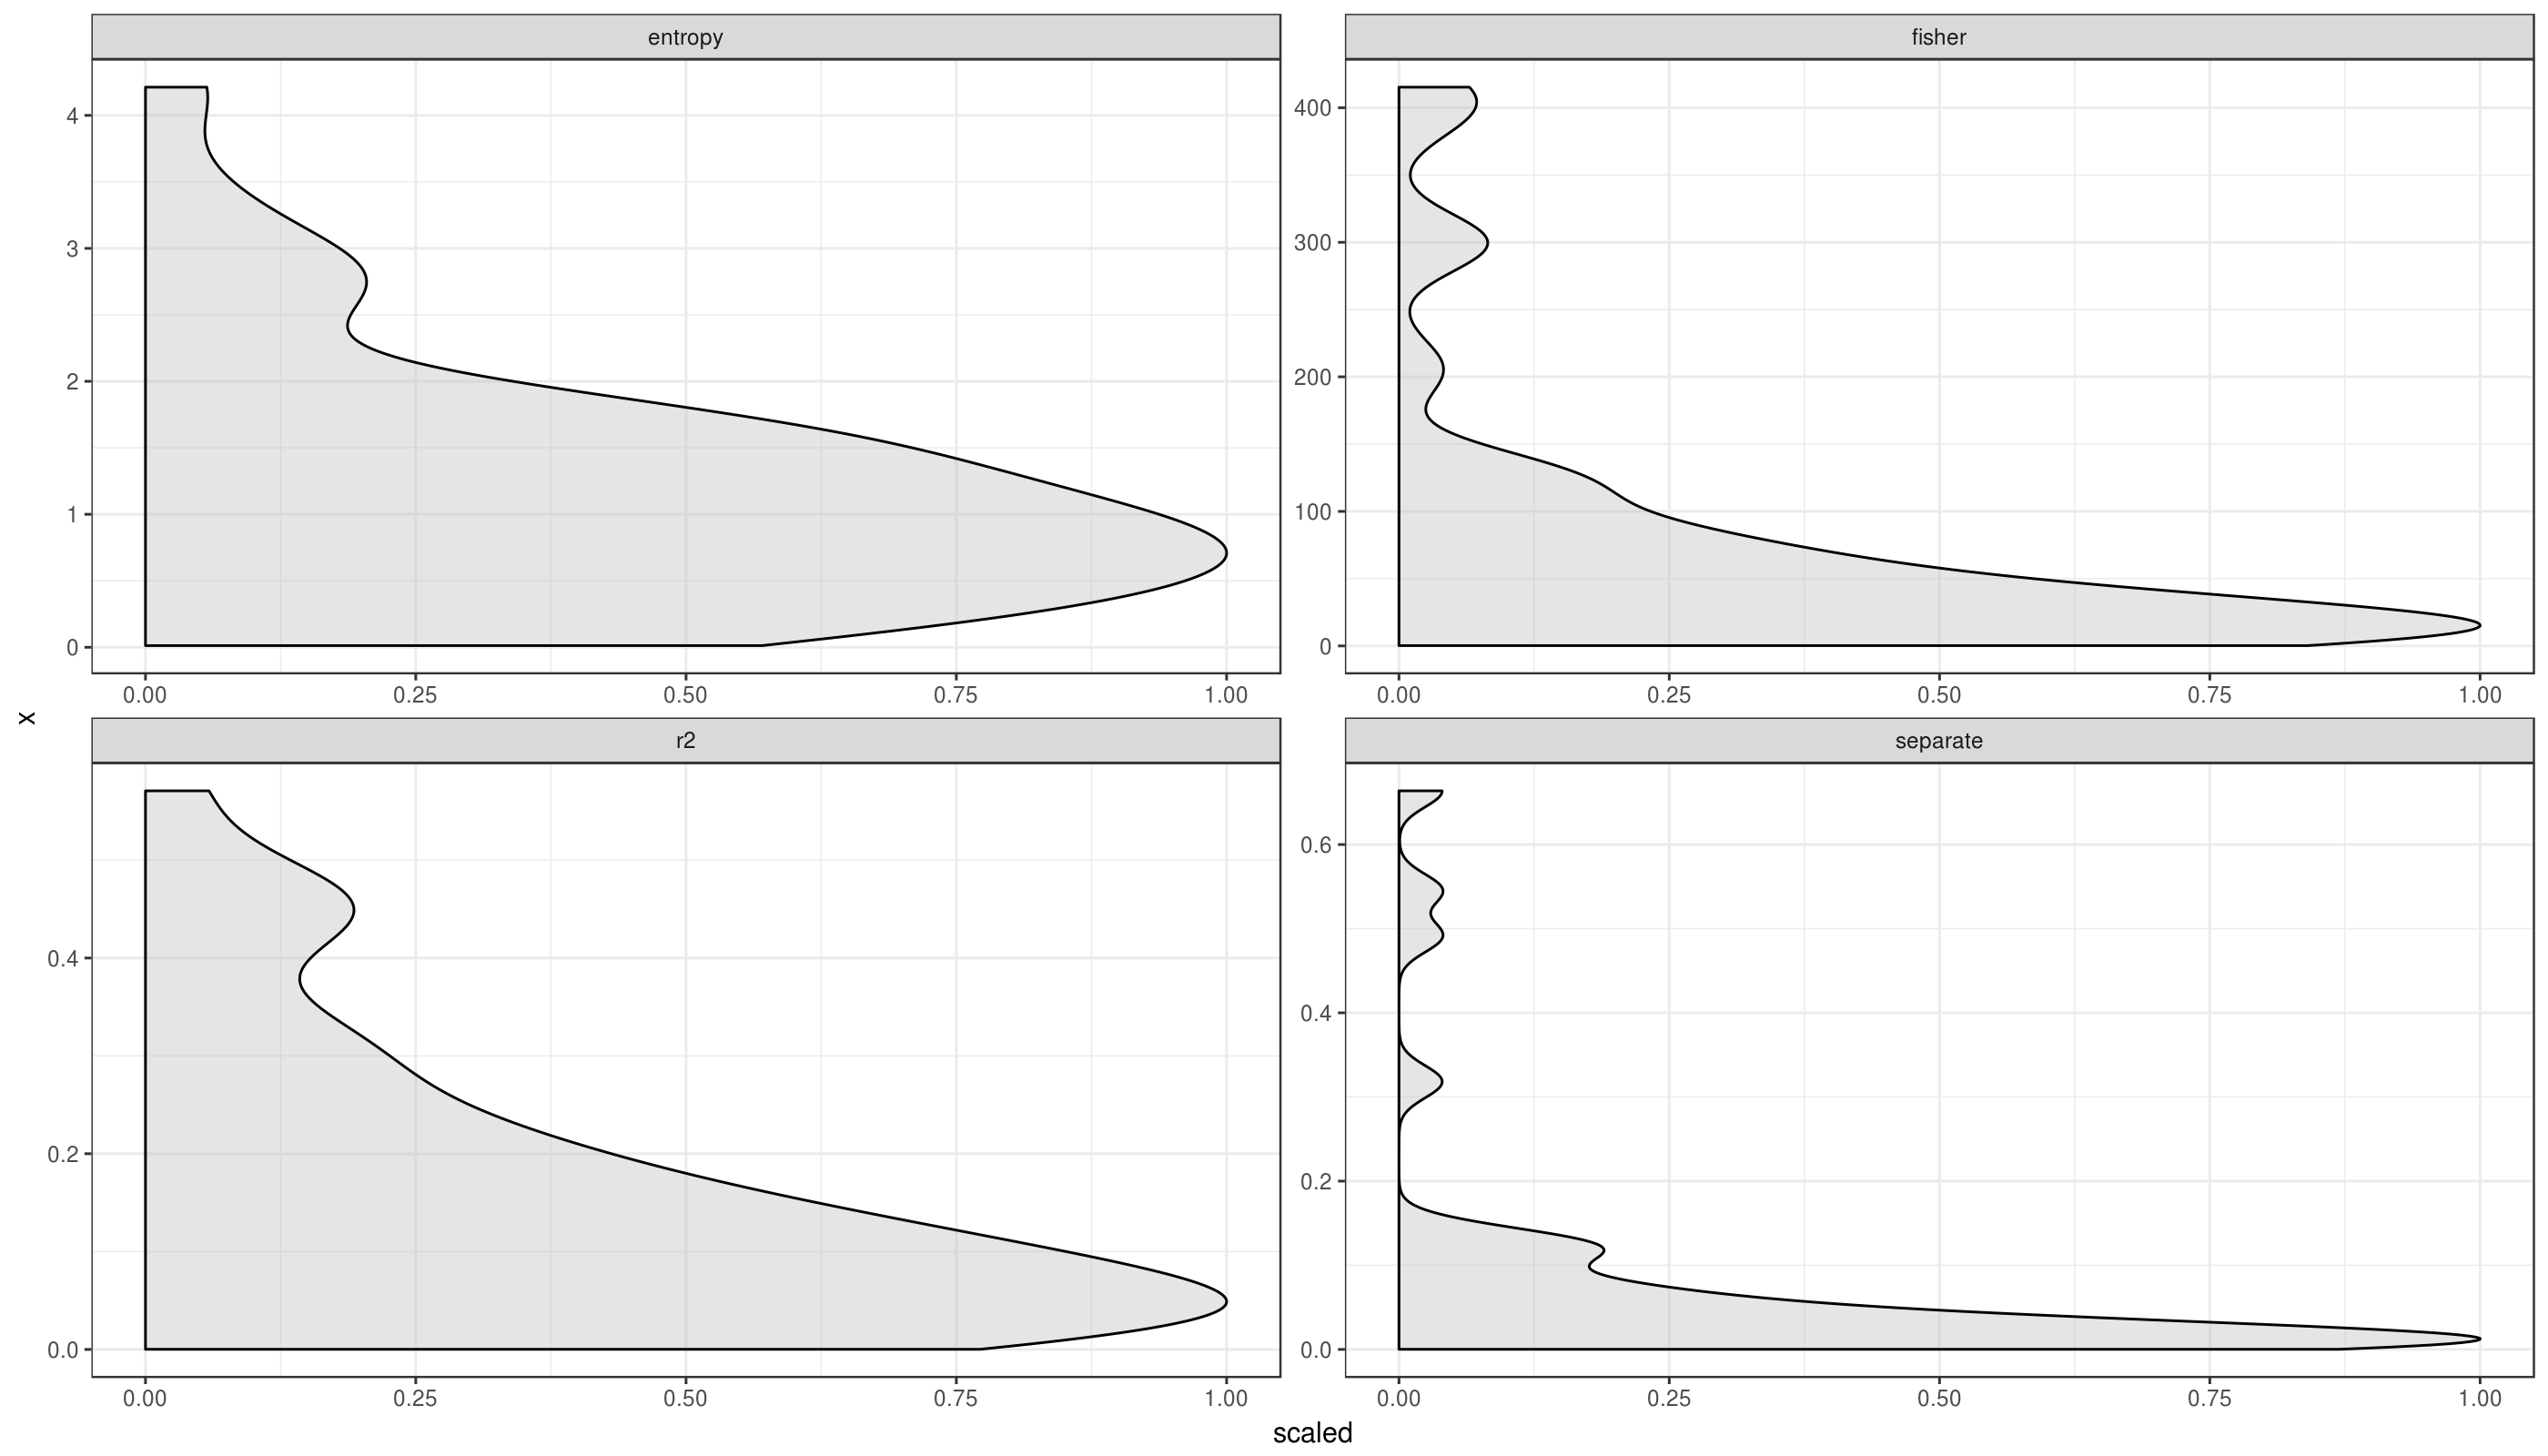

In [30]:
options(repr.plot.width = 14, repr.plot.height = 8, repr.plot.res=200)

entropy <- house_prices$attributes_selection$entropy
groups_separation <- house_prices$attributes_selection$groups_separation
Rsquared <- house_prices$attributes_selection$Rsquared
anova <- house_prices$attributes_selection$anova

df <- categ_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice)

cat_by_entropy <- entropy$arrange_vars(df %>% select(-price_log))
cat_by_groups_separation <- groups_separation$arrange_vars(df, price_log)
cat_by_r2 <- Rsquared$arrange_vars(df, price_log)
cat_by_fisher <- anova$arrange_vars(df, price_log)

bind_rows(
    cat_by_entropy %>% mutate(method = 'entropy') %>% rename(x=entropy),
    cat_by_groups_separation %>% mutate(method = 'separate') %>% rename(x=score),
    cat_by_r2 %>% mutate(method = 'r2') %>% rename(x=r2),
    cat_by_fisher %>% mutate(method = 'fisher') %>% rename(x=F)
) %>% 
ggplot(aes(x)) +
geom_density(aes(y=..scaled..), alpha=0.4, fill='grey') +
facet_wrap(~method, nrow=2, ncol=2, scales = "free") +
coord_flip() +
theme_bw()

In [31]:
x1 <- cat_by_entropy %>% filter(entropy < 1) %>% `[[`('var')
x2 <- cat_by_groups_separation %>% filter(score < 0.2) %>% `[[`('var')
x3 <- cat_by_r2 %>% filter(r2 < 0.1) %>% `[[`('var')
x4 <- cat_by_fisher %>% filter(F < 100) %>% `[[`('var')

cat_virgin_vars <- Reduce(intersect, list(x1, x2, x3, x4)) %>% sort
cat_chad_vars <- setdiff(categ_data %>% colnames, cat_virgin_vars) %>% sort

cat_virgin_vars
cat_chad_vars

[1] "BldgType"     "BsmtCond"     "BsmtFinType2" "Condition1"   "Condition2"  
 [6] "Electrical"   "ExterCond"    "Functional"   "GarageCond"   "GarageQual"  
[11] "Heating"      "LandContour"  "LandSlope"    "PavedDrive"   "RoofMatl"    
[16] "RoofStyle"    "Street"       "Utilities"

[1] "Alley"         "BsmtExposure"  "BsmtFinType1"  "BsmtQual"     
 [5] "CentralAir"    "Exterior1st"   "Exterior2nd"   "ExterQual"    
 [9] "Fence"         "FireplaceQu"   "Foundation"    "GarageFinish" 
[13] "GarageType"    "HeatingQC"     "HouseStyle"    "KitchenQual"  
[17] "LotConfig"     "LotShape"      "MasVnrType"    "MiscFeature"  
[21] "MoSold"        "MSSubClass"    "MSZoning"      "Neighborhood" 
[25] "PoolQC"        "SaleCondition" "SalePrice"     "SaleType"

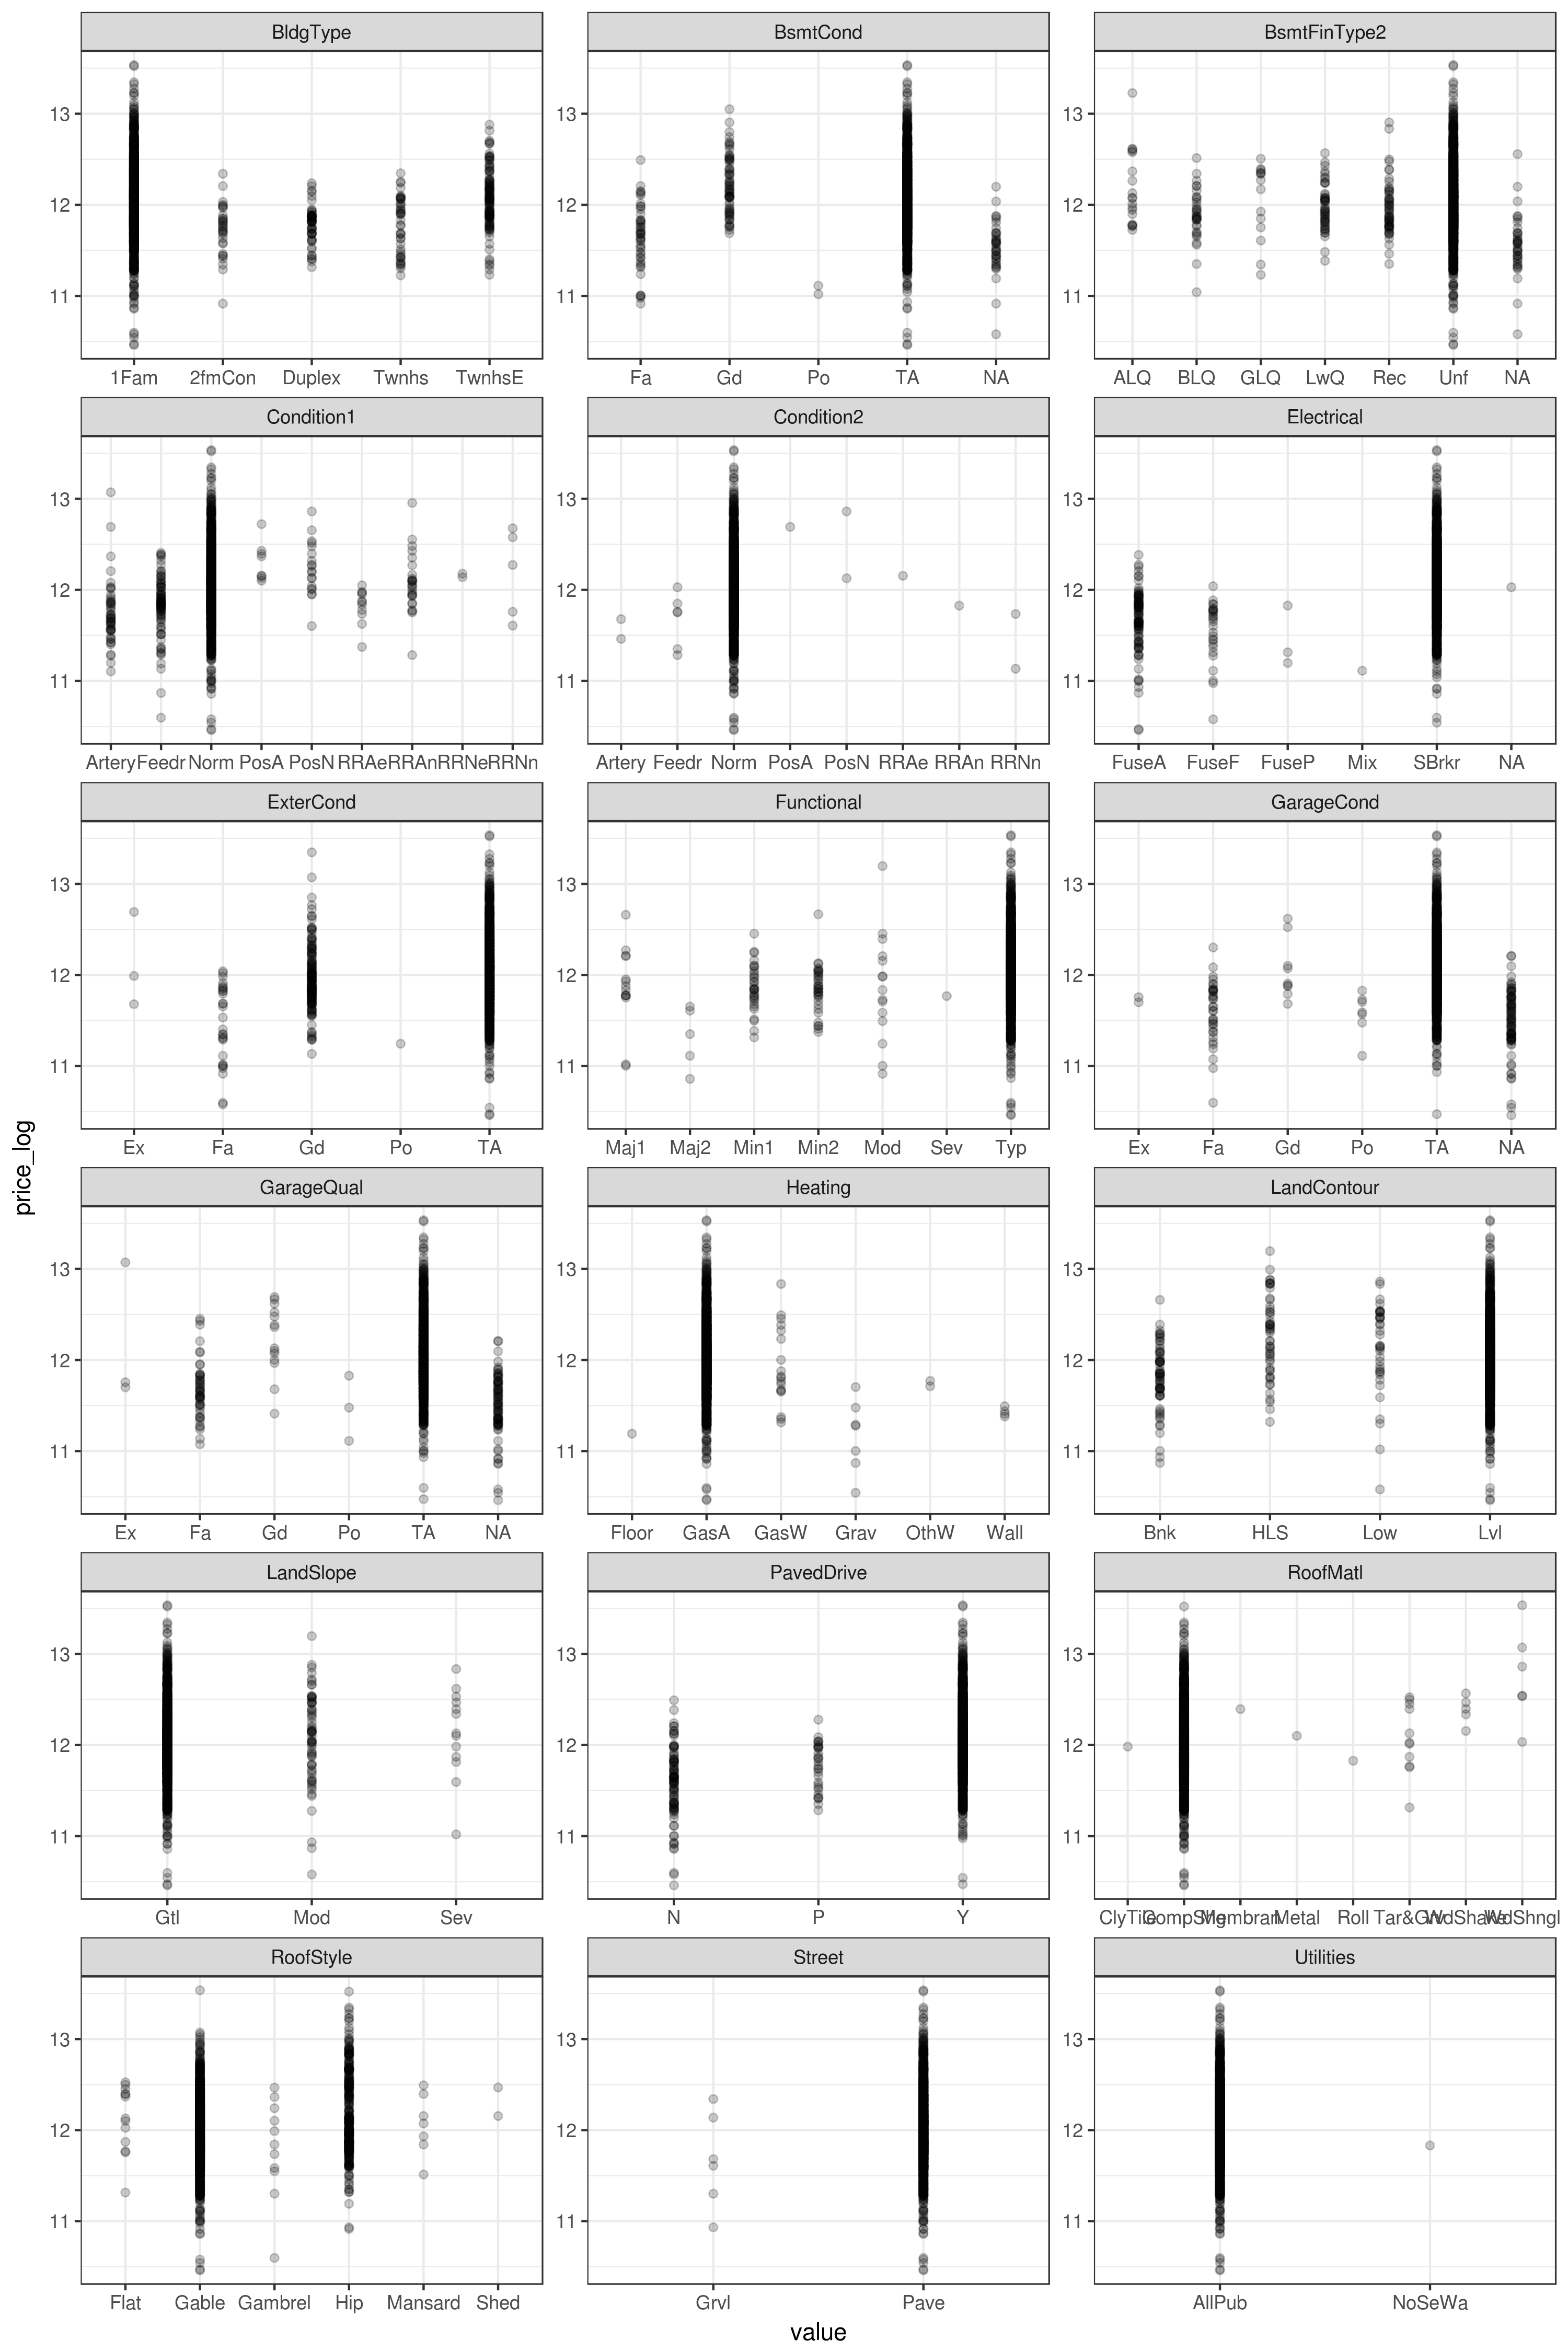

In [32]:
options(repr.plot.width = 10, repr.plot.height = 15, repr.plot.res=300)

categ_data %>%
mutate(price_log = log(SalePrice)) %>%
select(one_of(cat_virgin_vars), price_log) %>%
filter(!is.na(price_log)) %>%
gather(var, value, -price_log) %>%
ggplot(aes(x = value, y = price_log)) +
geom_point(alpha = 0.2) +
facet_wrap(~var, ncol=3, scale="free") +
theme_bw()

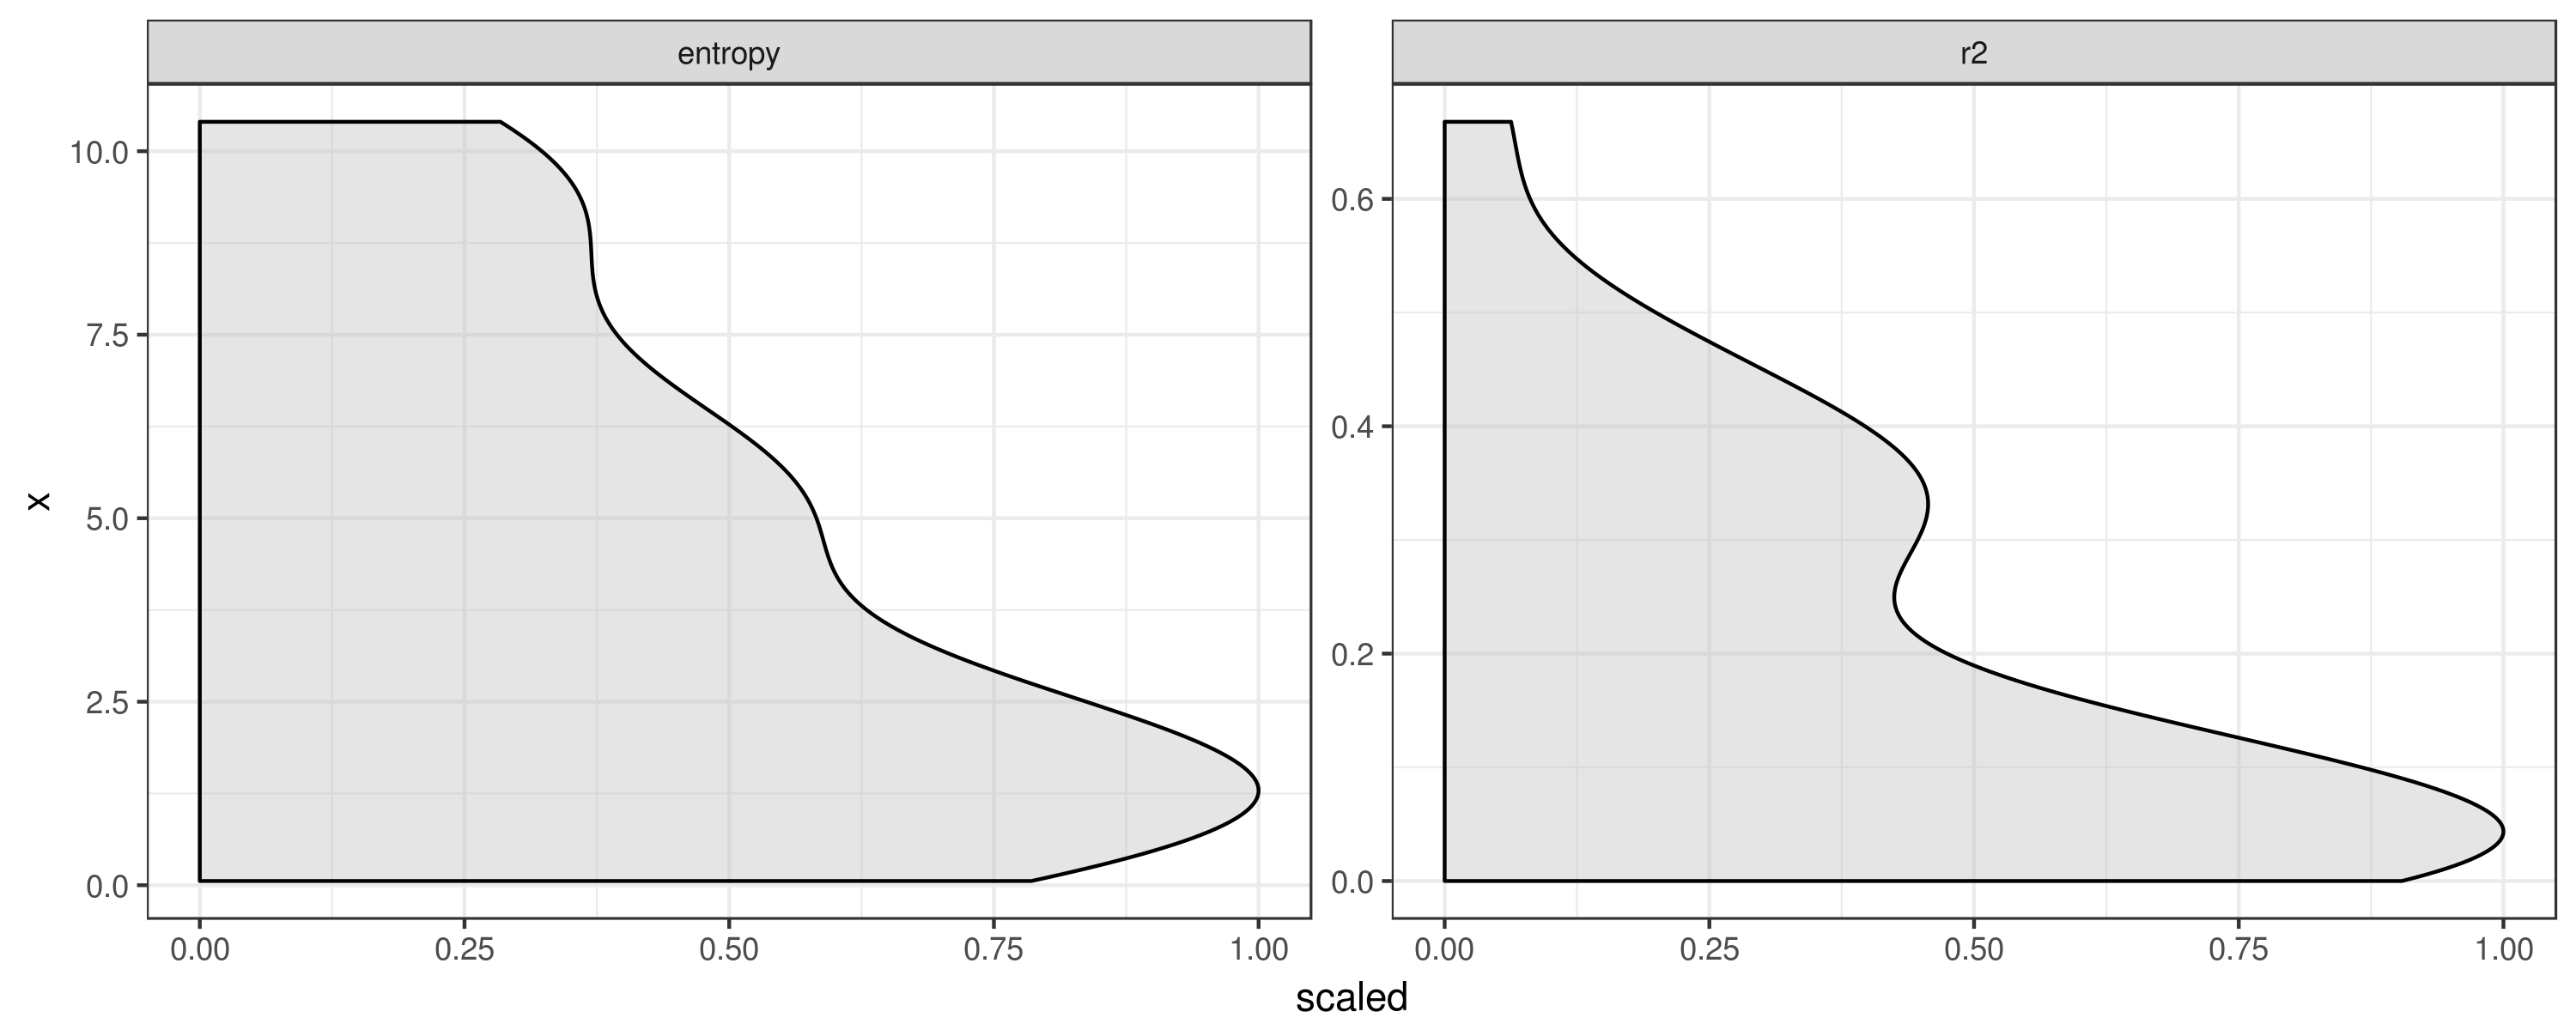

In [33]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res=300)

df <- numeric_data %>% mutate(price_log = log(SalePrice)) %>% select(-SalePrice)

num_by_entropy <- entropy$arrange_vars(df)
num_by_r2 <- Rsquared$arrange_vars(df, price_log)

bind_rows(
    num_by_entropy %>% mutate(method = 'entropy') %>% rename(x=entropy),
    num_by_r2 %>% mutate(method = 'r2') %>% rename(x=r2)
) %>%
ggplot(aes(x)) +
geom_density(aes(y=..scaled..), alpha=0.4, fill='grey') +
facet_wrap(~method, nrow=1, ncol=2, scales = "free") +
coord_flip() +
theme_bw()

In [34]:
x1 <- num_by_entropy %>% filter(entropy < 2) %>% `[[`('var')
x2 <- num_by_r2 %>% filter(r2 < 0.1) %>% `[[`('var')

num_virgin_vars <- Reduce(intersect, list(x1, x2)) %>% sort
num_chad_vars <- setdiff(numeric_data %>% colnames, num_virgin_vars) %>% sort

num_virgin_vars
num_chad_vars

[1] "BedroomAbvGr"  "BsmtFinSF2"    "BsmtFullBath"  "BsmtHalfBath" 
 [5] "EnclosedPorch" "HalfBath"      "KitchenAbvGr"  "LowQualFinSF" 
 [9] "MiscVal"       "OverallCond"   "PoolArea"      "ScreenPorch"  
[13] "X3SsnPorch"

[1] "BsmtFinSF1"   "BsmtUnfSF"    "Fireplaces"   "FullBath"     "GarageArea"  
 [6] "GarageCars"   "GarageYrBlt"  "GrLivArea"    "LotArea"      "LotFrontage" 
[11] "MasVnrArea"   "OpenPorchSF"  "OverallQual"  "SalePrice"    "TotalBsmtSF" 
[16] "TotRmsAbvGrd" "WoodDeckSF"   "X1stFlrSF"    "X2ndFlrSF"    "YearBuilt"   
[21] "YearRemodAdd" "YrSold"

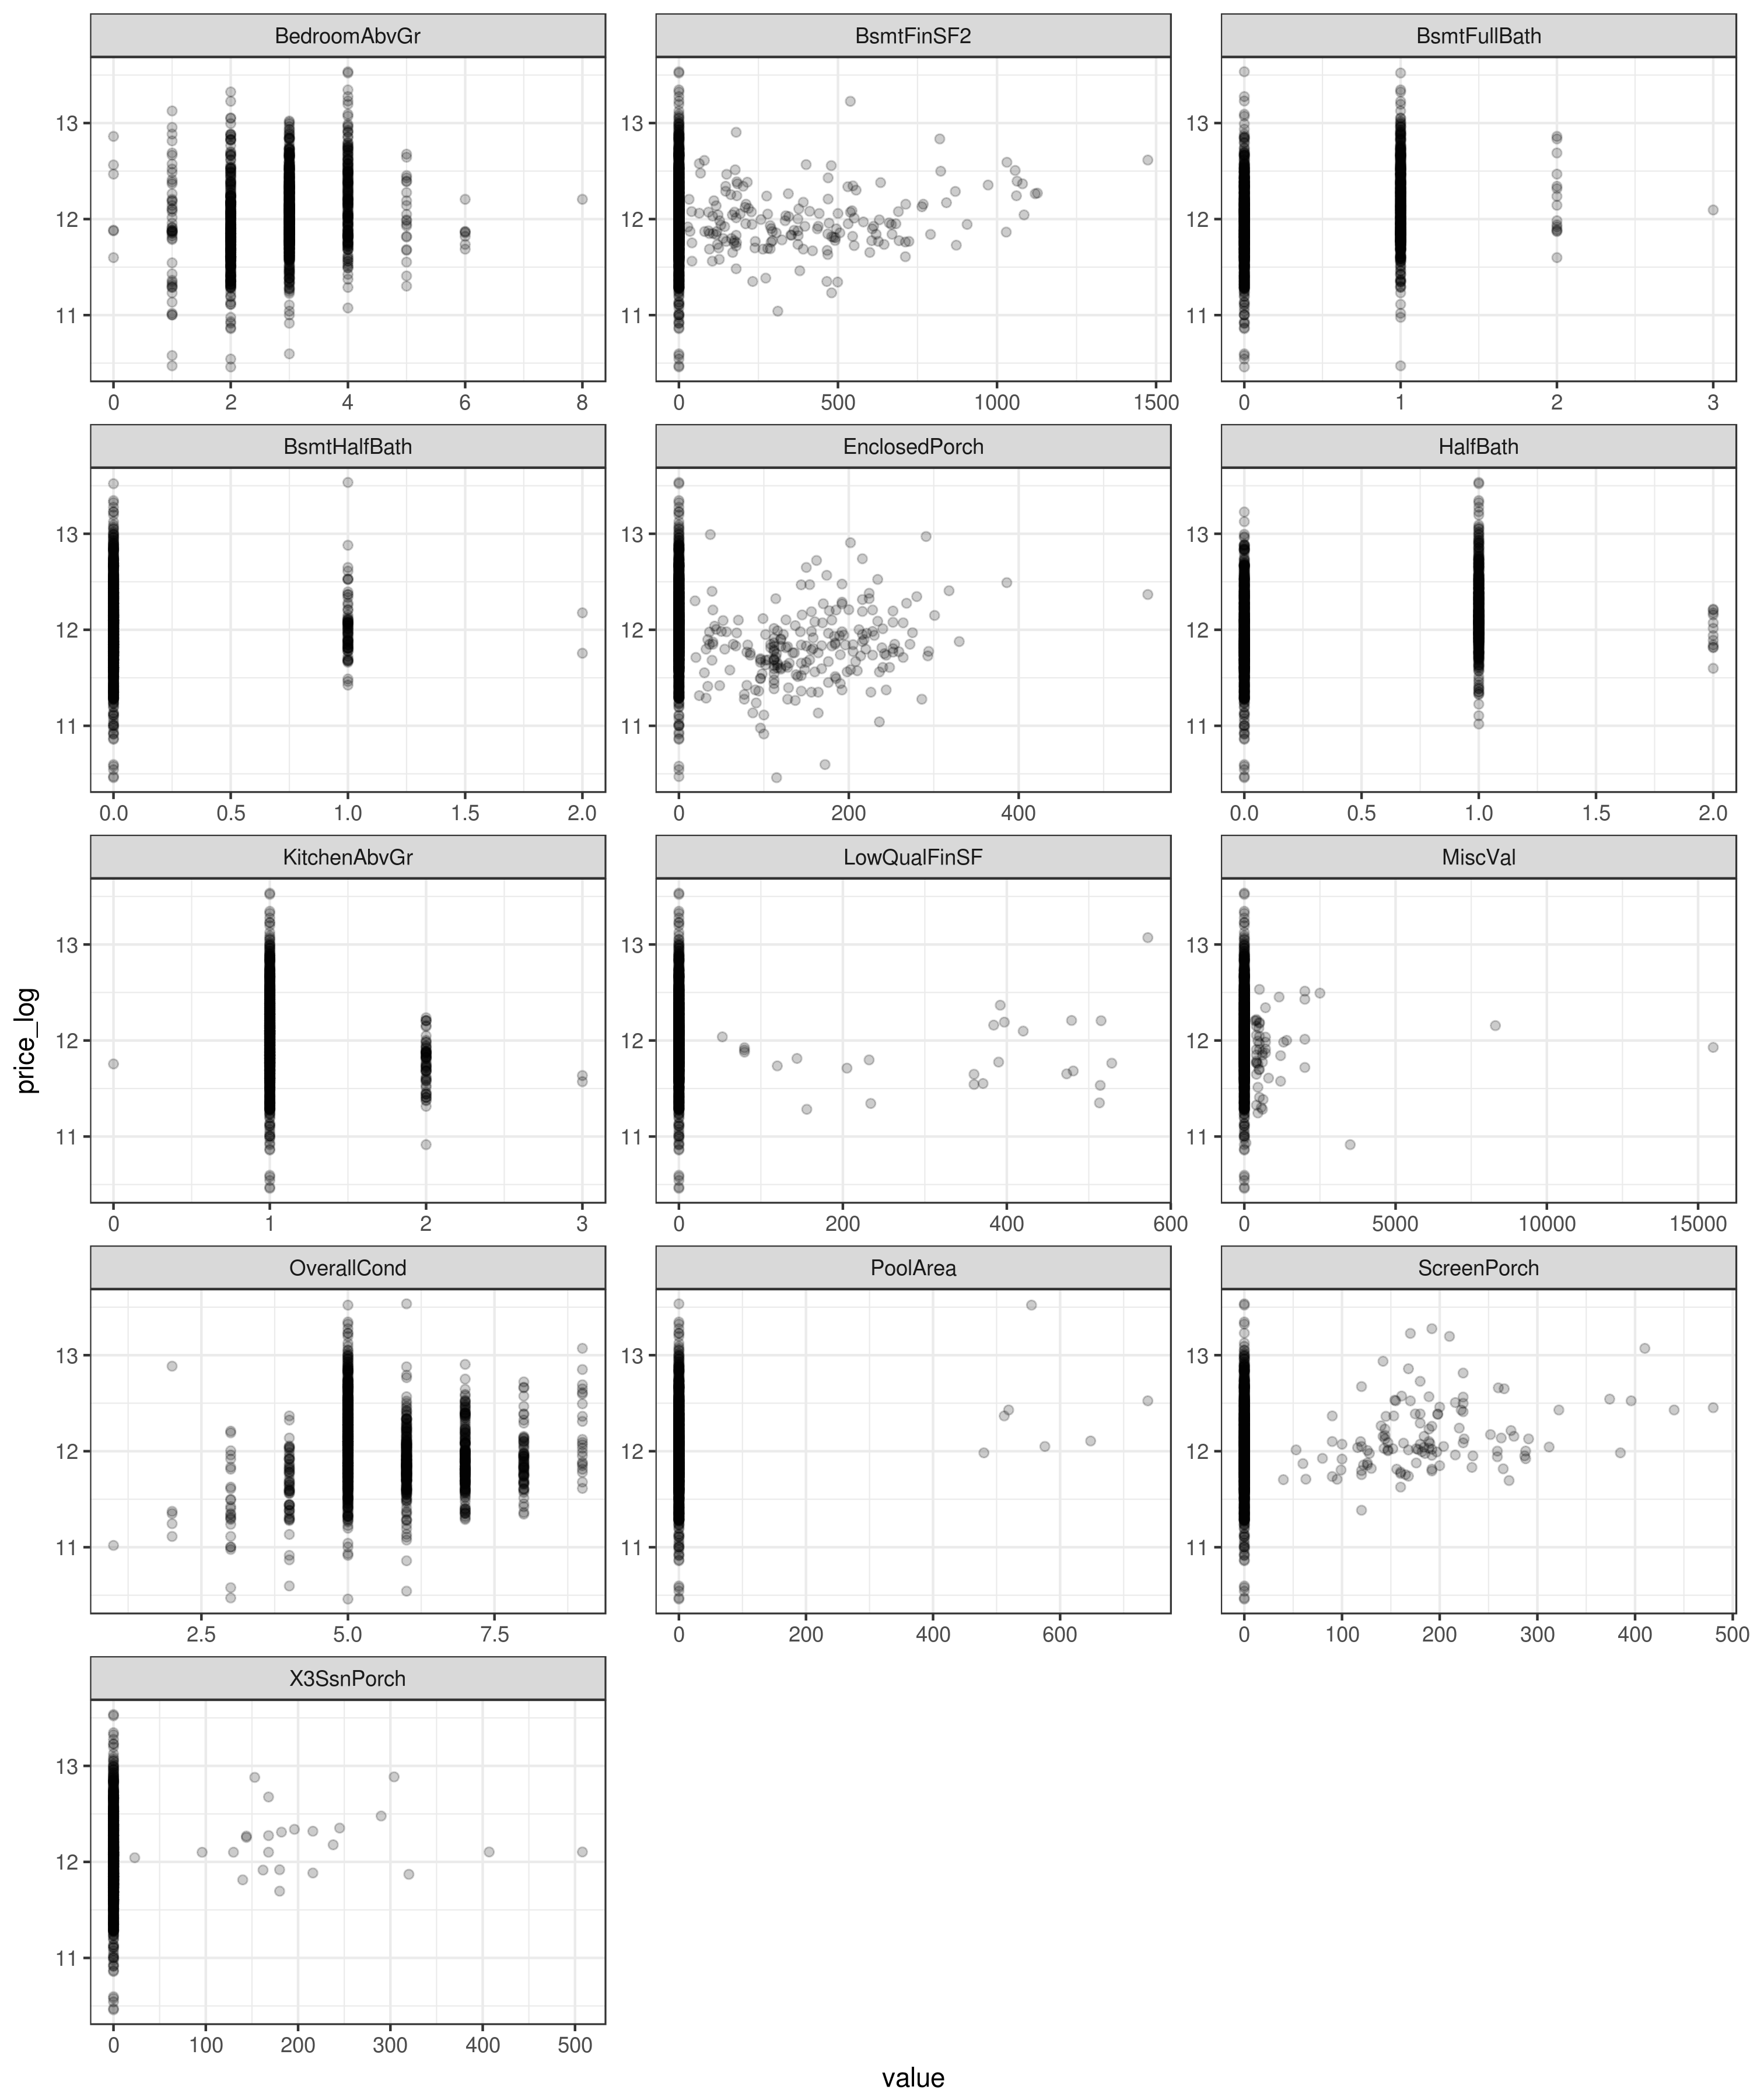

In [35]:
options(repr.plot.width = 10, repr.plot.height = 12, repr.plot.res=300)

numeric_data %>%
    mutate(price_log = log(SalePrice)) %>%
    select(one_of(num_virgin_vars), price_log) %>%
    filter(!is.na(price_log)) %>%
    gather(var, value, -price_log) %>%
    ggplot(aes(x = value, y = price_log)) +
    geom_point(alpha = 0.2) +
    facet_wrap(~var, ncol=3, scale="free") +
    theme_bw()